In [ ]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import torch
import torch.utils as utils
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
import torchvision
import sys

In [ ]:
IMG_SIZE = 256

EPOCHS = 1000
batch_size = 1
learning_rate = 0.001

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
loss1 = []
with open(r'/content/drive/MyDrive/Colab Notebooks/Model/loss_without_SAM', 'r') as fp:
    for line in fp:
        x = line[:-1]
        loss1.append(float(x))

In [ ]:
loss2 = []
with open(r'/content/drive/MyDrive/Colab Notebooks/Model/loss_with_GrayMask', 'r') as fp:
    for line in fp:
        x = line[:-1]
        loss2.append(float(x))

In [ ]:
loss3 = []
with open(r'/content/drive/MyDrive/Colab Notebooks/Model/loss_with_SAM', 'r') as fp:
    for line in fp:
        x = line[:-1]
        loss3.append(float(x))

In [ ]:
import matplotlib.pyplot as plt
import random

In [ ]:
x = range(1000)

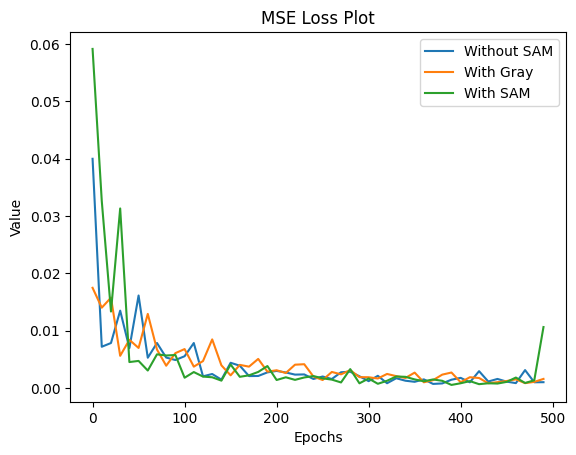

In [ ]:
plt.title('MSE Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.plot(x[0:500:10], loss1[0:500:10], label="Without SAM")
plt.plot(x[0:500:10], loss2[0:500:10], label="With Gray")
plt.plot(x[0:500:10], loss3[0:500:10], label="With SAM")
plt.legend()
plt.show()

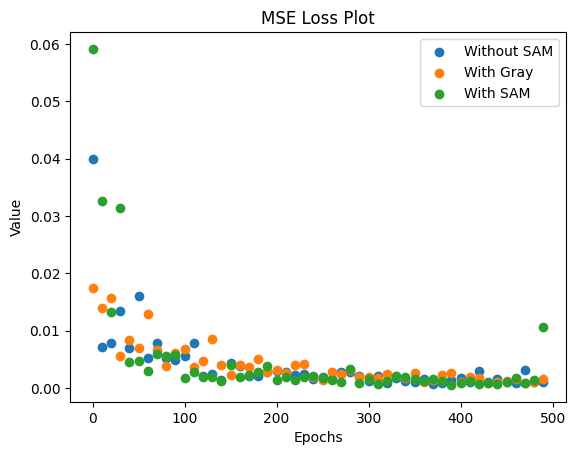

In [ ]:
plt.title('MSE Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.scatter(x[0:500:10], loss1[0:500:10], label="Without SAM")
plt.scatter(x[0:500:10], loss2[0:500:10], label="With Gray")
plt.scatter(x[0:500:10], loss3[0:500:10], label="With SAM")
plt.legend()
plt.show()

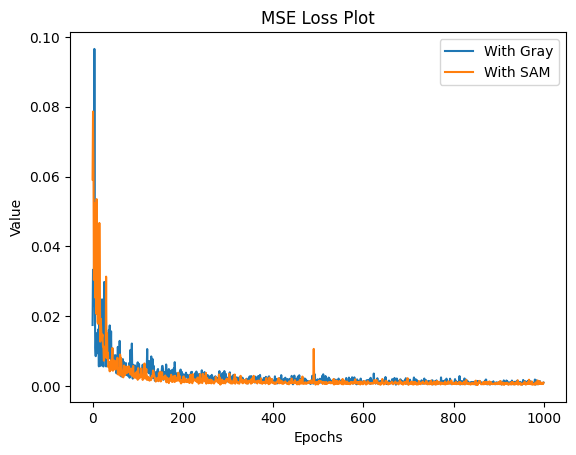

In [ ]:
plt.title('MSE Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.plot(x[0:1000], loss2[0:1000], label="With Gray")
plt.plot(x[0:1000], loss3[0:1000], label="With SAM")
plt.legend()
plt.show()

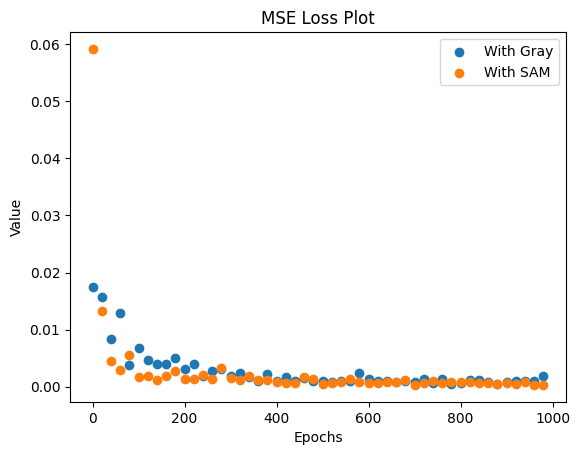

In [ ]:
plt.title('MSE Loss Plot')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.scatter(x[0:1000:20], loss2[0:1000:20], label="With Gray")
plt.scatter(x[0:1000:20], loss3[0:1000:20], label="With SAM")
plt.legend()
plt.show()

In [ ]:
###### Without Mask

In [ ]:
import torch

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(3,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 128 x 128
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 256 x 64 x 64
                        nn.ReLU()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.ConvTranspose2d(256,128,3,2,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,128,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.ConvTranspose2d(128,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.ConvTranspose2d(64,64,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
                        nn.ConvTranspose2d(64,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,32,3,1,1),
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.ConvTranspose2d(32,3,3,2,1,1),
                        nn.ReLU()
        )

    def forward(self,x):
        out = x.view(batch_size,256,64,64)
        out = self.layer1(out)
        out = self.layer2(out)
        return out

In [ ]:
encoder, decoder = torch.load('/content/drive/MyDrive/Colab Notebooks/Model/dehaze_autoencoder_normal.pkl')

In [ ]:
hazy_images_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/hazy'
ground_truth_path = '/content/drive/MyDrive/Colab Notebooks/Dataset/gt'

In [ ]:
test_images_hazy = []
test_images_gt = []

In [ ]:
for file in range(1101,1110):
  f = "{:d}".format(file) + '.png'
  path=os.path.join(hazy_images_path,f)
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(256, 256))
  test_images_hazy.append(np.array(img))

In [ ]:
for file in range(1101,1110):
  f = "{:d}".format(file) + '.png'
  path=os.path.join(ground_truth_path,f)
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(256, 256))
  test_images_gt.append(np.array(img))

In [ ]:
X_orig=torch.Tensor([test_images_gt[i] for i in range(len(test_images_gt))])
X_hazy=torch.Tensor([test_images_hazy[i] for i in range(len(test_images_hazy))])

X_orig=X_orig/255
X_hazy=X_hazy/255

In [ ]:
X_orig_flat=np.transpose(X_orig,(0,3,1,2))
X_hazy_flat=np.transpose(X_hazy,(0,3,1,2))

In [ ]:
test_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_flat,batch_size=batch_size,shuffle=False)

dehazed_output=[]
for test_hazy in tqdm(test_hazy_loader):
    hazy_image = Variable(test_hazy).cuda()

    encoder_op = encoder(hazy_image)
    output = decoder(encoder_op)

    output=output.cpu()
    output=output.detach()
    dehazed_output.append(output)

100%|██████████| 9/9 [00:00<00:00, 64.61it/s]


In [ ]:
X_dehazed=dehazed_output

X_dehazed=torch.stack(X_dehazed)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,1,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,3,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.permute(0,2,3,1)
print(X_dehazed.shape)

torch.Size([9, 1, 3, 256, 256])
torch.Size([27, 1, 256, 256])
torch.Size([9, 3, 256, 256])
torch.Size([9, 256, 256, 3])


In [ ]:
for i in range(0,len(X_orig)):

    fig=plt.figure(figsize=(15, 5))
    ax = plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(X_orig[i])

    ax = plt.subplot(132)
    plt.title('Hazy Image')
    plt.imshow(X_hazy[i])

    ax = plt.subplot(133)
    plt.title('Dehazed Image')
    plt.imshow(X_dehazed[i])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
###### With Gray Mask

In [ ]:
torch.cuda.empty_cache()

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder,self).__init__()
        self.layer1 = nn.Sequential(
                        nn.Conv2d(4,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,32,3,padding=1),   # batch x 32 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(32),
                        nn.Conv2d(32,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.Conv2d(64,64,3,padding=1),  # batch x 64 x 256 x 256
                        nn.ReLU(),
                        nn.BatchNorm2d(64),
                        nn.MaxPool2d(2,2)   # batch x 64 x 128 x 128
        )
        self.layer2 = nn.Sequential(
                        nn.Conv2d(64,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.Conv2d(128,128,3,padding=1),  # batch x 128 x 128 x 128
                        nn.ReLU(),
                        nn.BatchNorm2d(128),
                        nn.MaxPool2d(2,2),
                        nn.Conv2d(128,256,3,padding=1),  # batch x 256 x 64 x 64
                        nn.ReLU()
        )

    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1)
        return out

encoder = Encoder().cuda()

In [ ]:
encoder, decoder = torch.load('/content/drive/MyDrive/Colab Notebooks/Model/dehaze_autoencoder_gray.pkl')

In [ ]:
test_images_hazy = []
test_hazy_set = []
test_images_gt = []

In [ ]:
for file in range(1101, 1110):
  f = "{:d}".format(file) + '.png'
  path=os.path.join(ground_truth_path,f)
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(256, 256))
  test_images_gt.append(np.array(img))

In [ ]:
for file in range(1101, 1110):
  f = "{:d}".format(file) + '.png'
  path = os.path.join(hazy_images_path,f)
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(256, 256))
  test_hazy_set.append(img)
  img_mask = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
  img = np.dstack((img, img_mask))
  test_images_hazy.append(np.array(img))

In [ ]:
X_orig=torch.Tensor([test_images_gt[i] for i in range(len(test_images_gt))])
X_hazy=torch.Tensor([test_images_hazy[i] for i in range(len(test_images_hazy))])

X_orig=X_orig/255
X_hazy_seg=X_hazy/255

In [ ]:
X_orig_flat=np.transpose(X_orig,(0,3,1,2))
X_hazy_flat=np.transpose(X_hazy,(0,3,1,2))

In [ ]:
test_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_flat,batch_size=batch_size,shuffle=False)

dehazed_output=[]
for test_hazy in tqdm(test_hazy_loader):
    hazy_image = Variable(test_hazy).cuda()

    encoder_op = encoder(hazy_image)
    output = decoder(encoder_op)

    output=output.cpu()
    output=output.detach()
    dehazed_output.append(output)

100%|██████████| 9/9 [00:00<00:00, 67.62it/s]


In [ ]:
X_dehazed=dehazed_output

X_dehazed=torch.stack(X_dehazed)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,1,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,3,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.permute(0,2,3,1)
print(X_dehazed.shape)

torch.Size([9, 1, 3, 256, 256])
torch.Size([27, 1, 256, 256])
torch.Size([9, 3, 256, 256])
torch.Size([9, 256, 256, 3])


In [ ]:
for i in range(0,len(X_orig)):
    fig=plt.figure(figsize=(15, 5))
    ax = plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(X_orig[i])

    ax = plt.subplot(132)
    plt.title('Hazy Image')
    plt.imshow(test_hazy_set[i])

    ax = plt.subplot(133)
    plt.title('Dehazed Image')
    plt.imshow(X_dehazed[i])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
###### With SAM Large Mask

In [ ]:
torch.cuda.empty_cache()

In [ ]:
encoder, decoder = torch.load('/content/drive/MyDrive/Colab Notebooks/Model/dehaze_autoencoder_SAM.pkl')

In [ ]:
!pip install git+https://github.com/facebookresearch/segment-anything.git
!pip install opencv-python pycocotools matplotlib onnxruntime onnx
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/segment-anything.git'
#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth
#!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_b_01ec64.pth
!wget https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth

  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-h8riby44
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-h8riby44
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
  Cloning https://github.com/facebookresearch/segment-anything.git to /tmp/pip-req-build-fmv8uytm
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/segment-anything.git /tmp/pip-req-build-fmv8uytm
  Resolved https://github.com/facebookresearch/segment-anything.git to commit 6fdee8f2727f4506cfbbe553e23b895e27956588
  Preparing metadata (setup.py) ... done
--2023-10-05 10:37:56--  https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 3.163.180.9, 3.163.180.121, 3.163.180.70, ...
Con

In [ ]:
sys.path.append("..")
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor
#sam_checkpoint = "sam_vit_b_01ec64.pth"
sam_checkpoint = "sam_vit_l_0b3195.pth"
model_type = "vit_l"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

mask_generator = SamAutomaticMaskGenerator(sam)

In [ ]:
def gray_mask(masks):
    height = 256
    width = 256
    gray_mask = np.zeros((height, width), dtype=np.int64)

    for id, segment in enumerate(masks):
        seg_mask = segment['segmentation']
        area = segment['area']

        # Calculate the gray_mask using NumPy operations
        if id < 127:
            gray_mask += area * 2 * (id + 1) * seg_mask
        else:
            gray_mask += area * (2 * (255 - id) - 1) * seg_mask

    # Normalize the values to the range [0, 255]
    min_val = np.min(gray_mask)
    max_val = np.max(gray_mask)
    gray_mask = 255 * (gray_mask - min_val) / (max_val - min_val)
    gray_mask = gray_mask.astype(np.int64)
    return gray_mask

In [ ]:
test_images_hazy = []
test_images_gt = []
test_hazy_set = []

In [ ]:
for file in range(1101, 1110):
  f = "{:d}".format(file) + '.png'
  path=os.path.join(ground_truth_path,f)
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(256, 256))
  test_images_gt.append(np.array(img))

In [ ]:
for file in range(1101, 1110):
  f = "{:d}".format(file) + '.png'
  path = os.path.join(hazy_images_path,f)
  img = cv2.imread(path)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(256, 256))
  test_hazy_set.append(img)
  masks = mask_generator.generate(img)
  img_mask = gray_mask(masks)
  img = np.dstack((img, img_mask))
  test_images_hazy.append(np.array(img))

In [ ]:
X_orig=torch.Tensor([test_images_gt[i] for i in range(len(test_images_gt))])
X_hazy=torch.Tensor([test_images_hazy[i] for i in range(len(test_images_hazy))])

X_orig=X_orig/255
X_hazy_seg=X_hazy/255

In [ ]:
X_orig_flat=np.transpose(X_orig,(0,3,1,2))
X_hazy_flat=np.transpose(X_hazy,(0,3,1,2))

In [ ]:
test_hazy_loader = torch.utils.data.DataLoader(dataset=X_hazy_flat,batch_size=batch_size,shuffle=False)

dehazed_output=[]
for test_hazy in tqdm(test_hazy_loader):
    hazy_image = Variable(test_hazy).cuda()

    encoder_op = encoder(hazy_image)
    output = decoder(encoder_op)

    output=output.cpu()
    output=output.detach()
    dehazed_output.append(output)

100%|██████████| 9/9 [00:00<00:00, 68.21it/s]


In [ ]:
X_dehazed=dehazed_output

X_dehazed=torch.stack(X_dehazed)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,1,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.view(-1,3,256,256)
print(X_dehazed.size())

X_dehazed=X_dehazed.permute(0,2,3,1)
print(X_dehazed.shape)

torch.Size([9, 1, 3, 256, 256])
torch.Size([27, 1, 256, 256])
torch.Size([9, 3, 256, 256])
torch.Size([9, 256, 256, 3])


In [ ]:
for i in range(0,len(X_orig)):
    fig=plt.figure(figsize=(15, 5))
    ax = plt.subplot(131)
    plt.title('Original Image')
    plt.imshow(X_orig[i])

    ax = plt.subplot(132)
    plt.title('Hazy Image')
    plt.imshow(test_hazy_set[i])

    ax = plt.subplot(133)
    plt.title('Dehazed Image')
    plt.imshow(X_dehazed[i])
    plt.show()

Output hidden; open in https://colab.research.google.com to view.